In [1]:
import pandas as pd
import sklearn
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
from datasets import load_dataset
import tensorflow as tf
import tensorflow_addons as tfa
import gc

from keras import optimizers
import matplotlib.pyplot as plt
from keras import initializers
from keras.utils import np_utils
from keras import regularizers
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.layers import concatenate
from keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization, ReLU
from keras.layers import LSTM, Bidirectional
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score


import keras

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_goss_train = pd.read_pickle('../../Dissertation - Fake News/Embeddings/df_train_xception_block9_tuned.pkl')
df_goss_val = pd.read_pickle('../../Dissertation - Fake News/Embeddings/df_val_xception_block9_tuned.pkl')
df_goss_test = pd.read_pickle('../../Dissertation - Fake News/Embeddings/df_test_xception_block9_tuned.pkl')

In [3]:
df_goss_train.head()

,img_features,label,idx
1902,"[[0.20207693, 0.12428234, 0.0013508963, 0.0489...",0,1934
1386,"[[0.064614825, 0.07092466, 0.017142558, 0.0027...",0,1408
2539,"[[0.052746676, 0.052356396, 0.2536342, 0.01482...",0,2589
5649,"[[0.3931321, 0.4964808, 0.08978235, 0.14364813...",1,5778
2869,"[[0.00028831602, 0.010696825, 0.011921213, 0.0...",0,2922


In [4]:
def label_change(df):
    if df['label'] == 0: return 1
    else: return 0

In [5]:
df_goss_train['target'] = df_goss_train.apply(label_change, axis=1)
df_goss_train.head()

,img_features,label,idx,target
1902,"[[0.20207693, 0.12428234, 0.0013508963, 0.0489...",0,1934,1
1386,"[[0.064614825, 0.07092466, 0.017142558, 0.0027...",0,1408,1
2539,"[[0.052746676, 0.052356396, 0.2536342, 0.01482...",0,2589,1
5649,"[[0.3931321, 0.4964808, 0.08978235, 0.14364813...",1,5778,0
2869,"[[0.00028831602, 0.010696825, 0.011921213, 0.0...",0,2922,1


In [6]:
df_goss_val['target'] = df_goss_val.apply(label_change, axis=1)
df_goss_test['target'] = df_goss_test.apply(label_change, axis=1)

In [7]:
# Count samples per class: 0-real, 1-fake
classes_zero = df_goss_train[df_goss_train['target'] == 0]
classes_one = df_goss_train[df_goss_train['target'] == 1]

# Convert parts into NumPy arrays for weight computation
zero_numpy = classes_zero['target'].to_numpy()
one_numpy = classes_one['target'].to_numpy()
all_together = np.concatenate((zero_numpy, one_numpy))
unique_classes = np.unique(all_together)

# Compute weights
weights = sklearn.utils.class_weight.compute_class_weight('balanced', unique_classes, all_together)
print(weights)

[0.64400494 2.2360515 ]


C:\Users\labca\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [8]:
weights_ker = {i : weights[i] for i in range(2)}
weights_ker

{0: 0.6440049443757726, 1: 2.236051502145923}

In [9]:
array_train = df_goss_train[["img_features","target"]].to_numpy() 
X_train = np.array(array_train[:,0].tolist())
X_train.shape

(10420, 1, 2048)

In [10]:
X_train = np.squeeze(X_train, 1)
X_train.shape

(10420, 2048)

In [11]:
y_label = np.array(array_train[:,1].tolist())
y_label.shape

(10420,)

In [12]:
array_val = df_goss_val[["img_features","target"]].to_numpy() 
X_val = np.array(array_val[:,0].tolist())
X_val = np.squeeze(X_val, 1)
y_val_label = np.array(array_val[:,1].tolist())

array_test = df_goss_test[["img_features","target"]].to_numpy() 
X_test = np.array(array_test[:,0].tolist())
X_test = np.squeeze(X_test, 1)
y_test_label = np.array(array_test[:,1].tolist())

In [13]:
def reset_tensorflow_keras_backend():
    keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    _ = gc.collect()

In [14]:
def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))

In [15]:
adam = optimizers.Adam(learning_rate=1e-5)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [16]:
input_img = Input(shape=(2048))
img_dense = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01),\
                kernel_initializer=initializers.he_normal(seed=0))(input_img)
dropout_img = Dropout(0.4)(img_dense)
img_dense = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01),\
                kernel_initializer=initializers.he_normal(seed=0))(dropout_img)
img_dense = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01),\
                kernel_initializer=initializers.he_normal(seed=0))(dropout_img)
output = Dense(1, activation='sigmoid')(img_dense)
model = Model(inputs=input_img, outputs=output)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics='accuracy')

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               131200    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,229,505
Trainable params: 2,229,505
Non-trainable params: 0
_________________________________________________________________


In [18]:
def run_model(X_train, train_label, X_val, val_label, X_test, test_label, batch_size=32,epochs=100, verbose=1, class_weight=weights_ker, \
              itr=30, shuffle=True):
    
    adam = optimizers.Adam(learning_rate=1e-5)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    real_precision_list = []
    real_recall_list = []
    real_f1_list = []
    fake_precision_list = []
    fake_recall_list = []
    fake_f1_list = []
    
    macro_precision_list = []
    macro_recall_list = []
    macro_f1_list = []
    accuracy_list = []
    num_epochs = []

    #Define model
    input_img = Input(shape=(2048))
    dense_img = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01),\
                kernel_initializer=initializers.he_normal(seed=0))(input_img)
    dropout_img = Dropout(0.4)(dense_img)
    dense_img = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01),\
                kernel_initializer=initializers.he_normal(seed=0))(dropout_img)
    dense_img = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01),\
                kernel_initializer=initializers.he_normal(seed=0))(dense_img)
    output = Dense(1, activation='sigmoid')(dense_img)
    model = Model(inputs=input_img, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics='accuracy')
        
    for i in range(0,itr):
        print("\nTraining for iteration number: ", i)
        reset_tensorflow_keras_backend()
        reinitialize(model)
        history = model.fit(X_train, train_label, validation_data=(X_val, val_label), batch_size=batch_size,epochs=epochs,
                            callbacks=[callback], verbose=verbose, class_weight=class_weight, shuffle=shuffle)
        
        y_pred = model.predict(X_test)
        predictions = list(map(lambda x: 0 if x<0.5 else 1, y_pred))
        
        report = classification_report(y_test_label, predictions, target_names=['real','fake'], output_dict=True)
        real_precision = report['real']['precision'] 
        real_recall = report['real']['recall'] 
        real_f1 = report['real']['f1-score'] 
        fake_precision = report['fake']['precision'] 
        fake_recall = report['fake']['recall'] 
        fake_f1 = report['fake']['f1-score'] 
        
        macro_precision =  report['macro avg']['precision'] 
        macro_recall = report['macro avg']['recall']    
        macro_f1 = report['macro avg']['f1-score']
        accuracy = report['accuracy']

        real_precision_list.append(real_precision)
        real_recall_list.append(real_recall)
        real_f1_list.append(real_f1)
        fake_precision_list.append(fake_precision)
        fake_recall_list.append(fake_recall)
        fake_f1_list.append(fake_f1)
        
        macro_precision_list.append(macro_precision)
        macro_recall_list.append(macro_recall)
        macro_f1_list.append(macro_f1)
        accuracy_list.append(accuracy)
        num_epochs.append(len(history.history['loss']))
        
        
    mean_real_precision = np.mean(real_precision_list)
    mean_real_recall = np.mean(real_recall_list)
    mean_real_f1 = np.mean(real_f1_list)
    mean_fake_precision = np.mean(fake_precision_list)
    mean_fake_recall= np.mean(fake_recall_list)
    mean_fake_f1 = np.mean(fake_f1_list)
    
    mean_macro_precision = np.mean(macro_precision_list)
    mean_macro_recall = np.mean(macro_recall)
    mean_macro_f1 = np.mean(macro_f1_list)
    mean_accuracy = np.mean(accuracy_list)
    mean_epoch = np.mean(num_epochs)
    
    std_real_precision = np.std(real_precision_list)
    std_real_recall = np.std(real_recall_list)
    std_real_f1 = np.std(real_f1_list)
    std_fake_precision = np.std(fake_precision_list)
    std_fake_recall= np.std(fake_recall_list)
    std_fake_f1 = np.std(fake_f1_list)
    
    std_macro_precision = np.std(macro_precision_list)
    std_macro_recall = np.std(macro_recall)
    std_macro_f1 = np.std(macro_f1_list)
    std_accuracy = np.std(accuracy_list)

    print("The average real precision : ", mean_real_precision)
    print("The average real recall: ", mean_real_recall)
    print("The average real f1: ", mean_real_f1)
    print("The average fake precision : ", mean_fake_precision)
    print("The average fake recall: ", mean_fake_recall)
    print("The average fake f1: ", mean_fake_f1)
    print("The average macro precision: ", mean_macro_precision)
    print("The average macro recall: ", mean_macro_recall)
    print("The average macro_f1: ", mean_macro_f1)
    print("The average macro accuracy: ", mean_accuracy)
    
    print("The standard deviation on real precision : ", std_real_precision)
    print("The standard deviation on real recall: ", std_real_recall)
    print("The standard deviation on real f1: ", std_real_f1)
    print("The standard deviation on fake precision : ", std_fake_precision)
    print("The standard deviation on fake recall: ", std_fake_recall)
    print("The standard deviation on macro precision: ", std_macro_precision)
    print("The standard deviation on macro recall: ", std_macro_recall)
    print("The standard deviation on macro_f1: ", std_macro_f1)
    print("The standard deviation on macro accuracy: ", std_accuracy)
    print("Average number of epochs", mean_epoch)
    
    return real_precision_list, real_recall_list, real_f1_list, fake_precision_list, fake_recall_list, fake_f1_list,\
    macro_precision_list, macro_recall_list, macro_f1_list, accuracy_list

In [19]:
history = model.fit(X_train, y_label, validation_data=(X_val, y_val_label), batch_size=32,epochs=100,\
                            callbacks=[callback], verbose=1, class_weight=weights_ker, shuffle=True)

Epoch 1/100
326/326 [==============================] - 3s 5ms/step - loss: 22.4767 - accuracy: 0.7411 - val_loss: 21.2583 - val_accuracy: 0.6508
Epoch 2/100
326/326 [==============================] - 2s 5ms/step - loss: 20.0871 - accuracy: 0.7327 - val_loss: 19.0630 - val_accuracy: 0.6416
Epoch 3/100
326/326 [==============================] - 2s 6ms/step - loss: 17.9641 - accuracy: 0.7334 - val_loss: 17.1029 - val_accuracy: 0.6147
Epoch 4/100
326/326 [==============================] - 2s 5ms/step - loss: 16.0633 - accuracy: 0.7365 - val_loss: 15.2708 - val_accuracy: 0.6662
Epoch 5/100
326/326 [==============================] - 2s 5ms/step - loss: 14.3558 - accuracy: 0.7416 - val_loss: 13.6909 - val_accuracy: 0.6408
Epoch 6/100
326/326 [==============================] - 2s 5ms/step - loss: 12.8221 - accuracy: 0.7438 - val_loss: 12.2258 - val_accuracy: 0.6562
Epoch 7/100
326/326 [==============================] - 2s 5ms/step - loss: 11.4498 - accuracy: 0.7443 - val_loss: 10.9458 - val_ac

Epoch 58/100
326/326 [==============================] - 2s 5ms/step - loss: 0.6499 - accuracy: 0.8025 - val_loss: 0.8824 - val_accuracy: 0.6669
Epoch 59/100
326/326 [==============================] - 2s 5ms/step - loss: 0.6406 - accuracy: 0.8020 - val_loss: 0.8892 - val_accuracy: 0.6500
Epoch 60/100
326/326 [==============================] - 2s 5ms/step - loss: 0.6313 - accuracy: 0.8067 - val_loss: 0.8953 - val_accuracy: 0.6447
Epoch 61/100
326/326 [==============================] - 2s 5ms/step - loss: 0.6243 - accuracy: 0.8075 - val_loss: 0.8861 - val_accuracy: 0.6454
Epoch 62/100
326/326 [==============================] - 2s 5ms/step - loss: 0.6166 - accuracy: 0.8061 - val_loss: 0.8582 - val_accuracy: 0.6616
Epoch 63/100
326/326 [==============================] - 2s 5ms/step - loss: 0.6092 - accuracy: 0.8070 - val_loss: 0.8637 - val_accuracy: 0.6523
Epoch 64/100
326/326 [==============================] - 2s 5ms/step - loss: 0.6013 - accuracy: 0.8066 - val_loss: 0.8869 - val_accuracy:

In [20]:
real_precision, real_recall, real_f_score, fake_precision, fake_recall,\
fake_f1, macro_precision, macro_recall, macro_f1, accuracy = run_model(X_train, \
y_label, X_val, y_val_label, X_test, y_test_label, verbose=0, itr=30)


Training for iteration number:  0
41/41 [==============================] - 0s 1ms/step

Training for iteration number:  1
41/41 [==============================] - 0s 2ms/step

Training for iteration number:  2
41/41 [==============================] - 0s 2ms/step

Training for iteration number:  3
41/41 [==============================] - 0s 1ms/step

Training for iteration number:  4
41/41 [==============================] - 0s 1ms/step

Training for iteration number:  5
41/41 [==============================] - 0s 1ms/step

Training for iteration number:  6
41/41 [==============================] - 0s 1ms/step

Training for iteration number:  7
41/41 [==============================] - 0s 1ms/step

Training for iteration number:  8
41/41 [==============================] - 0s 1ms/step

Training for iteration number:  9
41/41 [==============================] - 0s 1ms/step

Training for iteration number:  10
41/41 [==============================] - 0s 1ms/step

Training for iteration number:

In [21]:
print("Real Precision:\n ", real_precision)
print("Real Recall:\n ", real_recall)
print("Real F1-Score:\n ",  real_f_score) 

Real Precision:
  [0.8232217573221757, 0.8322440087145969, 0.8266806722689075, 0.8278688524590164, 0.8325991189427313, 0.8269824922760041, 0.8277717976318623, 0.8291666666666667, 0.8353326063249727, 0.8314014752370916, 0.8331562167906482, 0.8255578093306288, 0.8276990185387132, 0.8284789644012945, 0.825, 0.8263103802672148, 0.8377445339470656, 0.8295687885010267, 0.8228228228228228, 0.8331454340473506, 0.8342480790340285, 0.8295918367346938, 0.8279569892473119, 0.8290322580645161, 0.8269430051813471, 0.8272251308900523, 0.8370846730975349, 0.8366666666666667, 0.8238396624472574, 0.8310160427807487]
Real Recall:
  [0.7723258096172718, 0.7497546614327772, 0.7723258096172718, 0.7929342492639843, 0.7419038272816487, 0.788027477919529, 0.7546614327772326, 0.7811579980372915, 0.7517173699705594, 0.774288518155054, 0.7693817468105987, 0.7988223748773308, 0.7448478900883219, 0.7536800785083415, 0.7772325809617272, 0.78900883218842, 0.7144259077526988, 0.7929342492639843, 0.8066732090284593, 0.

In [22]:
print("Fake Precision:\n ", fake_precision)
print("Fake Recall:\n ", fake_recall)
print("Fake F1-Score:\n ", fake_f1)

Fake Precision:
  [0.3314121037463977, 0.33766233766233766, 0.33903133903133903, 0.3547400611620795, 0.3341772151898734, 0.3493975903614458, 0.3315508021390374, 0.3498542274052478, 0.344559585492228, 0.3502824858757062, 0.35082872928176795, 0.35331230283911674, 0.32642487046632124, 0.3324468085106383, 0.33819241982507287, 0.3484848484848485, 0.3294930875576037, 0.3586626139817629, 0.3519736842105263, 0.3269230769230769, 0.3392857142857143, 0.3622291021671827, 0.3324396782841823, 0.3351206434316354, 0.34615384615384615, 0.34195402298850575, 0.3567567567567568, 0.3399503722084367, 0.3295774647887324, 0.3423913043478261]
Fake Recall:
  [0.40492957746478875, 0.45774647887323944, 0.41901408450704225, 0.4084507042253521, 0.4647887323943662, 0.4084507042253521, 0.43661971830985913, 0.4225352112676056, 0.46830985915492956, 0.43661971830985913, 0.4471830985915493, 0.39436619718309857, 0.44366197183098594, 0.44014084507042256, 0.4084507042253521, 0.40492957746478875, 0.5035211267605634, 0.415492

In [23]:
print("Macro Precision:\n ", macro_precision)
print("Macro Recall:\n ", macro_recall)
print("Macro F1-Score:\n ", macro_f1)
print("Accuracy Score:\n ", accuracy)

Macro Precision:
  [0.5773169305342867, 0.5849531731884673, 0.5828560056501233, 0.591304456810548, 0.5833881670663024, 0.5881900413187249, 0.5796612998854498, 0.5895104470359572, 0.5899460959086004, 0.5908419805563989, 0.5919924730362081, 0.5894350560848728, 0.5770619445025172, 0.5804628864559664, 0.5815962099125365, 0.5873976143760317, 0.5836188107523347, 0.5941157012413948, 0.5873982535166746, 0.5800342554852138, 0.5867668966598714, 0.5959104694509383, 0.580198333765747, 0.5820764507480758, 0.5865484256675966, 0.584589576939279, 0.5969207149271458, 0.5883085194375517, 0.5767085636179949, 0.5867036735642874]
Macro Recall:
  [0.5886276935410303, 0.6037505701530084, 0.595669947062157, 0.6006924767446682, 0.6033462798380075, 0.5982390910724406, 0.5956405755435459, 0.6018466046524485, 0.6100136145627445, 0.6054541182324565, 0.608282422701074, 0.5965942860302147, 0.5942549309596539, 0.596910461789382, 0.5928416425935397, 0.5969692048266044, 0.6089735172566311, 0.6042136035052316, 0.5917168

In [24]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [25]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

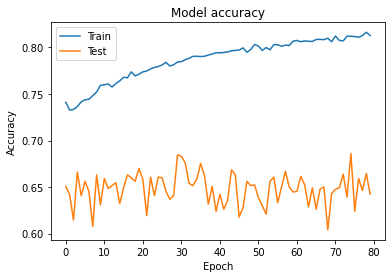

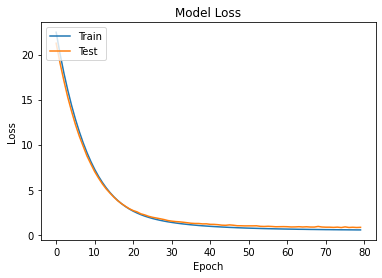

In [26]:
model_text_plotacc = plot_accuracy(history)
model_text_plotloss = plot_loss(history)